In [1]:
import sys, os, math
import numpy as np
sys.path.insert(0,os.path.expanduser('~/git/pyzx')) # git version
import pyzx as zx
from pyzx import print_matrix
from pyzx.basicrules import *
import time
from fractions import Fraction
import random
# zx.settings.drawing_backend = 'matplotlib'

Z = zx.VertexType.Z
X = zx.VertexType.X
B = zx.VertexType.BOUNDARY
SE = zx.EdgeType.SIMPLE
HE = zx.EdgeType.HADAMARD

In [12]:
g = zx.Graph()
g.add_vertex(qubit=0,row=0)
g.add_vertex(qubit=1,row=0)
g.add_vertex(ty=Z, qubit=0,row=1)
g.add_vertex(ty=Z, qubit=1,row=1)
g.add_vertex(ty=X, qubit=0.5,row=1.5)
g.add_vertex(qubit=0,row=2)
g.add_vertex(qubit=1,row=2)
g.add_edges([(0,2), (2,5), (1,3), (3,6), (2,4), (3,4)])
zx.draw(g,labels=True)
zx.clifford_simp(g)
zx.draw(g,labels=True)

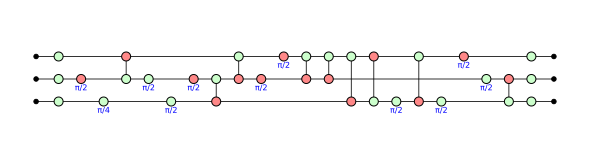

In [2]:
random.seed(1339)
g = zx.generate.cliffordT(3, 20, p_t=0.05)
zx.draw(g)

In [4]:
zx.quimb.to_quimb_tensor(g)

<TensorNetwork(tensors=58, indices=41)>

In [55]:
g1 = g.copy()
zx.full_reduce(g1)
g1.normalize()
zx.draw(g1)

In [58]:
c = zx.extract_circuit(g1.copy(), up_to_perm=True).to_basic_gates()
zx.optimize.basic_optimization(c)
g2 = c.to_graph()
zx.draw(g2)

In [59]:
for h,fname in [(g, "g.tikz"), (g1, "g1.tikz"), (g2, "g2.tikz")]:
    with open(fname, "w") as f:
        f.write(h.to_tikz())

In [ ]:
c = zx.qasm("""
qreg q[8];
rx(0.5*pi) q[4];
h q[7];
cx q[4], q[7];
rz(0.75*pi) q[7];
cx q[4], q[7];
h q[7];
rx(-0.5*pi) q[4];
rx(0.5*pi) q[2];
h q[7];
cx q[2], q[7];
rz(0.25*pi) q[7];
cx q[2], q[7];
h q[7];
rx(-0.5*pi) q[2];
h q[4];
rx(0.5*pi) q[7];
cx q[4], q[7];
rz(1.75*pi) q[7];
cx q[4], q[7];
rx(-0.5*pi) q[7];
h q[4];
h q[0];
cx q[0], q[5];
rz(0.25*pi) q[5];
cx q[0], q[5];
h q[0];
rx(0.5*pi) q[2];
cx q[2], q[7];
rz(0.75*pi) q[7];
cx q[2], q[7];
rx(-0.5*pi) q[2];
h q[7];
cx q[5], q[7];
rz(1.75*pi) q[7];
cx q[5], q[7];
h q[7];
h q[3];
h q[7];
cx q[3], q[7];
rz(1.75*pi) q[7];
cx q[3], q[7];
h q[7];
h q[3];
h q[1];
h q[3];
cx q[1], q[3];
rz(1.75*pi) q[3];
cx q[1], q[3];
h q[3];
h q[1];
h q[2];
rx(0.5*pi) q[4];
cx q[2], q[4];
rz(1.75*pi) q[4];
cx q[2], q[4];
rx(-0.5*pi) q[4];
h q[2];
h q[0];
h q[4];
cx q[0], q[4];
rz(1.25*pi) q[4];
cx q[0], q[4];
h q[4];
h q[0];
h q[1];
h q[6];
cx q[1], q[6];
rz(1.75*pi) q[6];
cx q[1], q[6];
h q[6];
h q[1];
rx(0.5*pi) q[3];
h q[7];
cx q[3], q[7];
rz(0.25*pi) q[7];
cx q[3], q[7];
h q[7];
rx(-0.5*pi) q[3];
h q[1];
cx q[1], q[4];
rz(1.25*pi) q[4];
cx q[1], q[4];
h q[1];
rx(0.5*pi) q[0];
rx(0.5*pi) q[6];
cx q[0], q[6];
rz(0.75*pi) q[6];
cx q[0], q[6];
rx(-0.5*pi) q[6];
rx(-0.5*pi) q[0];
rx(0.5*pi) q[0];
h q[1];
cx q[0], q[1];
rz(0.75*pi) q[1];
cx q[0], q[1];
h q[1];
rx(-0.5*pi) q[0];
cx q[5], q[6];
rz(1.75*pi) q[6];
cx q[5], q[6];
h q[2];
cx q[0], q[2];
rz(1.75*pi) q[2];
cx q[0], q[2];
h q[2];
rx(0.5*pi) q[2];
rx(0.5*pi) q[5];
cx q[2], q[5];
rz(1.75*pi) q[5];
cx q[2], q[5];
rx(-0.5*pi) q[5];
rx(-0.5*pi) q[2];
h q[4];
cx q[4], q[7];
rz(1.25*pi) q[7];
cx q[4], q[7];
h q[4];
h q[1];
rx(0.5*pi) q[7];
cx q[1], q[7];
rz(1.75*pi) q[7];
cx q[1], q[7];
rx(-0.5*pi) q[7];
h q[1];
""")

In [ ]:
zx.draw(c)

In [ ]:
g = c.to_graph()
g.apply_state("00000000")
g.apply_effect("00001111")
zx.draw(g)

In [ ]:
h = g + g.adjoint()
zx.draw(h)

In [ ]:
h.to_matrix()

In [ ]:
m = g.to_matrix()
len(m)
[(i,m[i]) for i in range(len(m)) if not np.isclose(m[i], 0)]

In [ ]:
g = zx.Graph()

ins = [g.add_vertex(B, 0, 1), g.add_vertex(B, 1, 1), g.add_vertex(B, 3, 1)]
outs = [g.add_vertex(B, 0, 5), g.add_vertex(B, 1, 5), g.add_vertex(B, 3, 5)]
zs = [g.add_vertex(Z, 0, 4), g.add_vertex(Z, 1, 4), g.add_vertex(Z, 2, 4, Fraction(-1,4)), g.add_vertex(Z, 3, 4, Fraction(-1,2))]
gs0 = [g.add_vertex(Z, 0.5, 3), g.add_vertex(Z, 1.5, 3), g.add_vertex(Z, 2.5, 3)]
gs1 = [g.add_vertex(Z, 0.5, 2, Fraction(-1,4)), g.add_vertex(Z, 1.5, 2, Fraction(-1,4)), g.add_vertex(Z, 2.5, 2, Fraction(1,4))]

g.add_edge((ins[0],zs[0]))
g.add_edge((zs[0],outs[0]))
g.add_edge((ins[1],zs[1]))
g.add_edge((zs[1],outs[1]))
g.add_edge((ins[2],zs[3]))
g.add_edge((zs[3],outs[2]))

for i in range(3): g.add_edge((gs0[i],gs1[i]),HE)
g.add_edge((gs0[0],zs[0]), HE)
g.add_edge((gs0[0],zs[2]), HE)
g.add_edge((gs0[1],zs[1]), HE)
g.add_edge((gs0[1],zs[2]), HE)
g.add_edge((gs0[2],zs[0]), HE)
g.add_edge((gs0[2],zs[1]), HE)
g.add_edge((gs0[2],zs[2]), HE)
g.add_edge((zs[2], zs[3]), HE)

g.set_inputs(ins)
g.set_outputs(outs)
zx.draw(g)

In [ ]:
m = g.to_matrix()
print((1 + 1j) * math.sqrt(2)**3 * m)

In [ ]:
(1/math.sqrt(2))**5

In [ ]:
# Generate a random circuit on 3 qubits, depth 20
#final version graph
g = zx.Graph()
#fourier thing
a0 = g.add_vertex(1, 0, 2,Fraction(1,4))
c0 = g.add_vertex(1, 2, 2,Fraction(1,4))
e0 = g.add_vertex(1, 4, 2,Fraction(1,4))

 

a1 = g.add_vertex(1, 0, 5)
c1 = g.add_vertex(1, 2, 5)
e1 = g.add_vertex(1, 4, 5)

 

b0 = g.add_vertex(1, 1, 0,Fraction(-1,4))
b1 = g.add_vertex(2, 1, 1)
b2 = g.add_vertex(2, 1, 3)
b3 = g.add_vertex(1, 1, 4,Fraction(-1,4))

 

d0 = g.add_vertex(1, 3, 0,Fraction(1,4))
d1 = g.add_vertex(2, 3, 1)
d2 = g.add_vertex(2, 3, 3)
d3 = g.add_vertex(1, 3, 4,Fraction(-1,4))

 

g.add_edges([(a0,a1),(c0,c1),(e0,e1),(b0,b1),(b2,b3),(d0,d1),(d2,d3)])
g.add_edges([(b1,a0),(b1,e0),(b2,a0),(b2,c0),(d1,a0),(d1,c0),(d1,e0),(d2,e0),(d2,c0)])

 

e2 = g.add_vertex(2, 4, 6,Fraction(1,2))
e3 = g.add_vertex(1, 4, 7)
e4 = g.add_vertex(2, 4, 8,Fraction(1,1))
e5 = g.add_vertex(1, 4, 9,Fraction(1,1))
e6 = g.add_vertex(2, 4, 10)
e7 = g.add_vertex(2, 4, 11)
e8 = g.add_vertex(1, 4, 12,Fraction(7,4))
e9 = g.add_vertex(2, 4, 13)
e10 = g.add_vertex(2, 4, 14)
e11 = g.add_vertex(1, 4, 15,Fraction(1,1))
e12 = g.add_vertex(0,4,16)
g.add_edges([(e1,e2),(e2,e3), (e3,e4),(e4,e5),(e5,e6),(e6,e7),(e7,e8),(e8,e9),(e9,e10),(e10,e11),(e11,e12)])
c2 =g.add_vertex(2, 2,7 )
a2 =g.add_vertex(2, 0,7 )
c3 =g.add_vertex(1, 2,10)
a3 =g.add_vertex(1, 0,11)
c4 =g.add_vertex(1, 2,13)
a4 =g.add_vertex(1, 0,14)
c5 =g.add_vertex(0, 2,16)
a5 =g.add_vertex(0, 0,16)
g.add_edges([(a1,a2),(a2,a3),(a3,a4),(a4,a5)])
g.add_edges([(c1,c2),(c2,c3),(c3,c4),(c4,c5)])
g.add_edges([(e3,a2),(e3,c2),(e6,c3),(e7,a3),(e9,c4),(e10,a4)])
g.set_phase(17,0)
g.set_phase(23,0)

display(zx.draw(g, labels=True))
zx.simplify.full_reduce(g)
display(zx.draw(g, labels=True))

In [ ]:
g.auto_detect_io()
g.to_matrix() * (-1/0.02209709j)

In [ ]:
h = zx.Graph()
h.add_vertex(ty=Z,qubit=0,row=1,phase=Fraction(1,4))
h.add_vertex(ty=Z,qubit=1,row=1,phase=Fraction(1,4))
h.add_vertex(ty=Z,qubit=2,row=1,phase=Fraction(1,4))
h.add_vertex(ty=B,qubit=0,row=2)
h.add_vertex(ty=B,qubit=1,row=2)
h.add_vertex(ty=B,qubit=2,row=2)
h.add_edge((0,3))
h.add_edge((1,4))
h.add_edge((2,5))
h.auto_detect_io()
zx.draw(h)

In [ ]:
h.to_matrix()

In [ ]:
c = zx.Circuit(1)
c.add_gate(zx.gates.ZPhase(0, 1/2))
c.add_gate(zx.gates.XPhase(0, 1/4))
c.add_gate(zx.gates.ZPhase(0, -1/2))
zx.draw(c)

In [ ]:
print("Loading circuit")
t = time.time()
c = zx.Circuit.load("../circuits/Slow/hwb8.qc")
t = time.time() - t
print("Done in %s ms" % (t*1000))

g = c.to_graph()
print("Simplifying")
t = time.time()
zx.simplify.interior_clifford_simp(g, quiet=True)
t = time.time() - t
print("Done in %s ms" % (t*1000))

print("Extracting")
t = time.time()
c1 = zx.extract_circuit(g, optimize_cnots=0, optimize_czs=False)
t = time.time() - t
print("Done in %s ms" % (t*1000))

In [ ]:
c = zx.qasm("""
qreg q[5];
cx q[3], q[4];
tdg q[4];
cx q[0], q[3];
tdg q[3];
cx q[0], q[3];
cx q[1], q[4];
cx q[0], q[4];
cx q[1], q[4];
tdg q[4];
t q[0];
""")
zx.draw(c)

In [ ]:
c1 = zx.qasm("""
qreg q[5];
h q[4];
h q[3];
h q[0];
h q[4];
h q[3];
h q[0];
cx q[0], q[1];
cx q[1], q[2];
cx q[2], q[0];
rz(-0.25*pi) q[3];
h q[3];
rz(-0.25*pi) q[0];
h q[0];
cz q[4], q[0];
h q[0];
rz(-0.25*pi) q[4];
cz q[3], q[0];
h q[3];
rz(0.25*pi) q[0];
""")
zx.draw(c1)

In [ ]:
zx.compare_tensors(c, c1, preserve_scalar=False)

In [ ]:
g = c.to_graph()
zx.full_reduce(g)
g.normalize()
zx.draw(g)

In [ ]:
g1 = c1.to_graph()
zx.full_reduce(g1)
g1.normalize()
zx.draw(g1)

In [ ]:
c1 = zx.qasm("""
qreg q[5];
cx q[4], q[2];
cx q[2], q[4];
cx q[4], q[2];
h q[4];
h q[4];
h q[3];
h q[3];
h q[2];
h q[1];
h q[1];
h q[0];
h q[0];
cz q[2], q[1];
cz q[1], q[0];
rz(-0.5*pi) q[1];
h q[1];
cz q[1], q[0];
rz(-0.5*pi) q[0];
h q[0];
cz q[4], q[2];
cz q[3], q[2];
cz q[2], q[0];
h q[2];
cz q[4], q[3];
cz q[4], q[0];
cz q[4], q[2];
rz(-0.75*pi) q[4];
h q[4];
cz q[4], q[2];
cz q[4], q[1];
cz q[4], q[3];
rz(0.25*pi) q[4];
cz q[3], q[0];
cz q[3], q[2];
rz(0.75*pi) q[3];
cz q[2], q[0];
rz(0.75*pi) q[2];
rz(-0.5*pi) q[1];
h q[1];
rz(1*pi) q[0];
""")
zx.draw(c1)

In [ ]:
g1 = c1.to_graph()
zx.spider_simp(g1)
zx.id_simp(g1)
zx.draw(g)
zx.draw(g1)

In [ ]:
zx.compare_tensors(g, g1)

In [ ]:
zx.compare_tensors(c, c1, preserve_scalar=True)

In [ ]:
g = c.to_graph()
g1 = c1.to_graph()
zx.spider_simp(g)
zx.to_gh(g1)
zx.spider_simp(g1)
zx.draw(g)
zx.draw(g1)

In [ ]:
m = zx.Mat2.id(4)
m.gauss(full_reduce=True, blocksize=3)
m

In [ ]:
t = time.time()
c = zx.Circuit.load('../circuits/feyn_bench/qasm/hwb12.qasm')
t = time.time() - t
print("Done in %s ms" % (t * 1000))
c

In [ ]:
sz = 100000

print("Building a Z-spider chain of size: %s" % sz)
t = time.time()
g = zx.Graph()
g.add_vertex(ty=Z)
for i in range(1, sz):
    g.add_vertex(ty=Z)
    g.add_edge((i-1, i))
t = time.time() - t
print("Done in %s ms" % (t * 1000))

print("Fusing all spiders")
t = time.time()
while any(fuse(g, g.edge_s(e), g.edge_t(e)) for e in g.edges()):
    pass
t = time.time() - t
print("Done in %s s" % t)
g

In [ ]:
g = zx.Circuit.load("../circuits/Fast/QFT8_before").to_graph()
qft_stats = zx.simplify.Stats()
zx.full_reduce(g, stats=qft_stats)
print(qft_stats)

In [ ]:
random.seed(1337)
c0 = zx.generate.CNOT_HAD_PHASE_circuit(5, 100)
print(c0.stats())
g = c0.to_graph()
stats = zx.simplify.Stats()
zx.full_reduce(g, stats=stats)
g.normalize()
g = g.copy()

In [ ]:
stats.num_rewrites

In [ ]:
zx.draw(g, labels=True)

In [ ]:
1 == Fraction(1)

In [ ]:
def frontier(g):
    fr = set()
    for i,o in enumerate(g.outputs):
        v = list(g.neighbors(o))[0]
        if v in g.inputs: continue
        fr.add(v)
    return fr

def is_gadget(g, v):
    return g.type(v) == 1 and len(g.neighbors(v)) == 1
    
def is_gadget_hub(g, v):
    return g.type(v) == 1 and any(is_gadget(g,n) for n in g.neighbors(v))

def ungadget(g, fr):
    for f in fr:
        for n in g.neighbors(f):
            if is_gadget(g, n):
                gen_pivot(g, f, n)
                return True
    return False

def make_gadget(g, fr):
    for f in fr:
        for n in g.neighbors(f):
            if g.type(n) == 1 and g.phase(n) != 0 and g.phase(n) != 1:
                gen_pivot(g, f, n)
                return True
    return False

def make_gadgets(g):
    fr = frontier(g1)
    while make_gadget(g1, fr): pass
    
def maximal(g):
    mx = set()
    fr = frontier(g)
    for f in fr:
        for n in g.neighbors(f):
            if g.type(n) == 1 and not n in fr: mx.add(n)
    return mx

In [ ]:
g1 = g.copy()
#make_gadgets(g1)
out = set(g1.outputs)
fr = frontier(g1)
while ungadget(g1, fr): pass
mx = maximal(g1)
last = max(mx, key=lambda v: g1.row(v))

frlist = list(fr)
mxlist = list(mx)
print(frlist)
print(mxlist)
print(last)

# m = bi_adj(g1, mxlist, frlist)
# print(m)
# print(m.transpose().nullspace())
# print(frlist)
gen_pivot(g1, 19, 20)

fr = frontier(g1)
#while ungadget(g1, fr): pass
mx = maximal(g1)

print(fr)
print(mx)
m = bi_adj(g1, mx, fr)
print(m)

zx.draw(g1, labels=True)

In [ ]:
def normalize_io(g):
    shifti = False
    shifto = False
    iset = set(g.inputs)
    oset = set(g.outputs)
    for b in g.inputs + g.outputs:
        if len(g.neighbors(b)) != 0:
            nb = next(iter(g.neighbors(b)))
            if g.phase(nb) != 0:
                if b in iset: shifti = True
                else: shifto = True
                
                e = g.edge(b,nb)
                et = g.edge_type(e)
                g.remove_edge(e)
                v = g.add_vertex(1, row=g.row(b), qubit=g.qubit(b))
                if et == 1:
                    g.add_edge((b,v), 2)
                else:
                    g.add_edge((b,v), 1)
                g.add_edge((v,nb),2)
    
    if shifti or shifto:
        for v in g.vertices():
            sh = 0
            if shifti and not v in iset: sh += 1
            if shifto and v in oset: sh += 1
            g.set_row(v, g.row(v) + sh)
    return (shifti, shifto)

In [ ]:
g = zx.Graph()

In [ ]:
round(g.scalar.to_number().real)

In [ ]:
g.scalar

In [ ]:
from pyzx.routing.parity_maps import CNOT_tracker
from pyzx.routing.steiner import steiner_gauss
from pyzx.routing.architecture import Architecture

# Architecture is given as a numpy adjacency matrix. N.b. nodes must
# be ordered such that (0,1,...,n-1) is a Hamiltonian path.

# Six qubits in a 3x2 grid.
arch = Architecture("test", coupling_matrix=np.array(
[[0,1,0,0,0,1],
 [1,0,1,0,1,0],
 [0,1,0,1,0,0],
 [0,0,1,0,1,0],
 [0,1,0,1,0,1],
 [1,0,0,0,1,0]]
))


# MUST BE FULL RANK
m = zx.Mat2([[1,0,1,1,0,0],
             [0,1,1,0,1,1],
             [1,1,0,0,1,0],
             [1,0,1,0,1,1],
             [1,1,1,1,0,0],
             [1,1,0,0,1,1]])

# CNOT_tracker is a subclass of Circuit that implements row_add by appending CNOT
# gates.
c = CNOT_tracker(6)
m1 = m.copy()

# y is an optional parameter that tracks inverse row operations. If it is passed
# a CNOT_tracker, this produces the CNOT decomposition of m1.
#m1.gauss(full_reduce=True,y=c)
steiner_gauss(m1,arch,full_reduce=True,y=c)

print("PARITY MATRIX:")
print(m)
print("m rank:", m.rank())
print("gates:", c.gates)
print("correct CNOT circuit:", c.matrix == m)

In [ ]:
g = c.to_graph()
g.map_qubits([
    (0,0), (1, 0), (2, 0),
    (2,1), (1, 1), (0, 1)
])

for v in g.vertices(): g.set_row(v, g.row(v)/2)

zx.draw(g)

In [ ]:
c = zx.qasm("""
qreg q[2];
t q[0];
h q[1];
cz q[0],q[1];
h q[1];
cz q[0],q[1];

""")

In [ ]:
c = zx.qasm("""
qreg q[4];
h q[0];
rz(0.125*pi) q[2];
s q[0];
cx q[2],q[3];
cx q[1],q[2];
x q[3];
cx q[0],q[1];
cx q[2],q[3];
tdg q[1];
cx q[0],q[1];
cx q[1],q[2];
rz(-0.125*pi) q[2];
z q[0];
""")

zx.draw(c)

In [ ]:
g = c.to_graph()
zx.full_reduce(g)
zx.draw(g)

In [ ]:
random.seed(1337)
c = zx.generate.CNOT_HAD_PHASE_circuit(4, 200, p_had=0.3, p_t=0.4)
# c.gates.append(zx.gates.HAD(0))
# c.gates.append(zx.gates.HAD(1))
# c.gates.append(zx.gates.HAD(2))
# c.gates.append(zx.gates.HAD(3))
# c.add_circuit(zx.generate.CNOT_HAD_PHASE_circuit(4, 100, p_had=0))
zx.draw(c)

In [ ]:
def unfuse(g,v):
    v1 = g.add_vertex(1, phase=g.phase(v), row=g.row(v),qubit=-1)
    g.add_edge((v1,v))
    g.set_phase(v,0)
    return v1
def gpivot(g,v1,v2):
    n1 = [w for w in g.neighbors(v1) if g.vertex_degree(w)==1]
    n2 = [w for w in g.neighbors(v2) if g.vertex_degree(w)==1]
    zx.rules.apply_rule(g, zx.rules.pivot, [(v1,v2,n1,n2)])
    q,r = g.qubit(v1), g.row(v1)
    g.set_position(v1, g.qubit(v2), g.row(v2))
    g.set_position(v2, q, r)
def frontier(g):
    return set.union(*[set(g.neighbors(o)) for o in g.outputs])
def maximal(g):
    fr = frontier(g)
    mx = set()
    for v in g.vertices():
        nhd = g.neighbors(v)
        if g.type(v) == 1 and any(n in fr for n in nhd) and all(g.type(n) != 0 for n in nhd):
            mx.add(v)
    return mx

def fix_max(g):
    hit = True
    while hit:
        fr = frontier(g)
        print(fr)
        for f in fr:
            if g.phase(f): g.set_phase(f, 0)
        out = set(g.outputs)
        hit = False
        mx = maximal(g)
        for m in mx:
            if g.phase(m) != 0 and g.phase(m) != 1:
                m1 = unfuse(g, m)
                f1 = None
                for f in g.neighbors(m):
                    b = [f1 for f1 in g.neighbors(f) if g.type(f1)==0]
                    if len(b) == 1 and b[0] in out:
                        f1 = b[0]
                        break
                if not f1:
                    raise ValueError("no suitable neighbor found")
                #zx.rules.apply_rule(g, zx.rules.pivot, [(m,f,[m1],[f1])])
                gpivot(g,m,f)
                hit = True
                break

In [ ]:
random.seed(1337)
c = zx.generate.CNOT_HAD_PHASE_circuit(4, 200, p_had=0, p_t=0.4)
g = c.to_graph()
zx.full_reduce(g)
g.normalize()
g = g.copy()
g.set_phase(4, 0)
g.set_phase(7, 0)
g.set_phase(13,0)
gpivot(g,13,8)
gpivot(g,9,7)
gpivot(g,12,4)
zx.spider_simp(g)
#fix_max(g)
# g(12) = {12, 25, 26}
# Odd(g(12)) = {20}
#gpivot(g,4,25)
#gpivot(g,7,26)
zx.draw(g, labels=True)

In [ ]:
random.seed(1337)
c = zx.generate.CNOT_HAD_PHASE_circuit(4, 200, p_had=0.3, p_t=0.4)
g = c.to_graph()
zx.full_reduce(g)
g.normalize()
g = g.copy()
g.set_phase(26,0)
g.set_phase(28,0)
unfuse(g,27)
gpivot(g,27,28)
# g(28) = {28, 31}
# Odd(g(28)) = {27, 30}
unfuse(g,29)
gpivot(g,29,31)
unfuse(g,25)
gpivot(g,25,26)
zx.draw(g,labels=True)

In [ ]:
vs = [4,3,6,8,10,5,11,9,7]

In [ ]:
m0 = zx.extract.bi_adj(g, [4,3,6,8,10,5], [8,10,5,11,9,7])
m0.rank()

In [ ]:
m = zx.linalg.Mat2([[1 if g.connected(i,j) else 0 for i in vs] for j in vs])
m.rank()

In [ ]:
id9 = zx.linalg.Mat2.id(9)

In [ ]:
input_pr = zx.linalg.Mat2([[1 if i == j and i > 2 else 0 for i in range(9)] for j in range(9)])
input_pr

In [ ]:
output_pr = zx.linalg.Mat2([[1 if i == j and i < 6 else 0 for i in range(9)] for j in range(9)])
output_pr

In [ ]:
pc_op = zx.linalg.Mat2.id(7)
pc_op.col_add(4,3)
pc_op.col_add(6,0)
pc_op.col_add(5,1)
pc_op.col_add(4,2)
c = id9 #input_pr * pc_op * output_pr
gc = m * c
print(c)
print()
print(gc)

In [ ]:
fr = frontier(g)
mx = maximal(g)
m = next(iter(mx))
f = next(f for f in g.neighbours(m) if f in fr)
(m,f)

In [ ]:
g = c.to_graph()
zx.full_reduce(g)
g.normalise()
g = g.copy()
v1 = unfuse(g,17)
zx.rules.apply_rule(g,zx.rules.pivot,[(6,17,[0],[v1])])
v2 = unfuse(g,4)
zx.rules.apply_rule(g,zx.rules.pivot,[(4,5,[v2],[3])])
g.normalise()
zx.draw(g,labels=True)

In [ ]:
m = zx.extract.bi_adj(g, maximal(g), frontier(g))
print(m)
m.gauss(full_reduce=True)
print()
print(m)

In [ ]:
random.seed(1338)
qs = 4
c = zx.Circuit(qs)

for i in range(40):
    ctrl = random.randint(0,qs-1)
    targ = random.randint(0,qs-2)
    if targ == ctrl: targ += 1
    c.add_gate("CNOT", ctrl, targ)
    c.add_gate("T", targ)
    c.add_gate("CNOT", ctrl, targ)
zx.draw(c)

In [ ]:
g = c.to_graph()
zx.simplify.full_reduce(g)
g.normalise()
zx.draw(g)

In [ ]:
g1 = g.copy()
fix_max(g1)
g1.normalise()
zx.rules.apply_rule(g1,zx.rules.pivot,[(12,20,[0],[15])])

In [ ]:
zx.draw(g1, labels=True)

In [ ]:
ge = g.copy()
ce = zx.extract_circuit(ge)
zx.draw(ce)

In [ ]:
g1 = g.copy()
g1.normalise()
# squash phases on boundary
# g1.set_phase(14, 0)
# g1.set_phase(13, 0)

# pivot away gadgets
#zx.rules.apply_rule(g1,zx.rules.pivot,[(9,14,[],[17])])

zx.draw(g1,labels=True)

In [ ]:
g = zx.Graph()

greens = 4
reds = 3
for i in range(greens):
    g.add_vertex(ty=1, qubit=i, row=1)
for i in range(reds):
    v = g.add_vertex(ty=2, qubit=i, row=3)
    g.set_phase(v, 1)

random.seed(1337)
p_edge = 0.5
for i in range(greens):
    for j in range(greens, greens+reds):
        if random.random() < p_edge:
            g.add_edge((i,j))
zx.draw(g)

In [ ]:
zx.full_reduce(g)

In [ ]:
g.scalar

In [ ]:
g = zx.qasm("""
qreg q[3];

ccz q[0],q[1],q[2];
h q[2];
t q[2];
ccz q[0],q[1],q[2];
h q[2];
t q[1];
ccz q[0],q[1],q[2];
s q[2];
ccx q[0],q[1],q[2];
""").to_graph(zh=True)
zx.draw(g, labels=True)

In [ ]:
h = g.copy()
zx.simplify.spider_simp(h)
zx.hsimplify.to_hbox(h)
m = zx.hrules.match_hpivot(h)
print(m)
display(zx.draw(h,labels=True))
zx.hrules.hpivot(h,m)
display(zx.draw(h,labels=True))

In [ ]:
zx.hsimplify.hpivot_simp(g)
zx.d3.draw(g, labels=True)

In [ ]:
qs = 10
d = 60
c = zx.Circuit(qs)
p_t = 0
p_h = 0.3
random.seed(1338)
for i in range(d):
    p = random.random()
    if p < p_h:
        c.add_gate(zx.circuit.HAD(random.randint(0,qs-1)))
    elif p < p_t + p_h:
        c.add_gate(zx.circuit.T(random.randint(0,qs-1)))
    else:
        q = sorted(random.sample(range(qs), 3))
        c.add_gate(zx.circuit.CCZ(q[0],q[1],q[2]))

In [ ]:
zx.d3.draw(c.to_graph(zh=True))

In [ ]:
g = c.to_graph(zh=True)
zx.hsimplify.hpivot_simp(g)
g.normalise()
zx.d3.draw(g)

In [ ]:
[len([v for v in g.vertices() if g.type(v) == t]) for t in [1,3]]

In [ ]:
[max([g.vertex_degree(v) for v in g.vertices() if g.type(v) == t]) for t in [1,3]]

In [ ]:
zx.compare_tensors(c.to_graph(zh=True), g)

In [ ]:
d = { 'a': 3, 'b': 4, 'c': 3}
list(filter(lambda v: v > 3, d.values()))

In [ ]:
a = [1,2,3]
a.append(4)
a

In [ ]:
2**9

In [ ]:
c1 = zx.Circuit.load('../circuits/Fast/QFT8_before')
c1

In [ ]:
g = c1.to_graph(zh=True)
zx.hsimplify.hpivot_simp(g)
g.normalise()
print("Normal form: ", end='')
print(g.qubit_count() * 2 == len([v for v in g.vertices() if g.type(v) == 1]))
zx.d3.draw(g)

In [ ]:
[len([v for v in g.vertices() if g.type(v) == t]) for t in [1,3]]

In [ ]:
g.qubit_count() * 2 == len([v for v in g.vertices() if g.type(v) == 1])

In [ ]:
os.path.join('..', 'circuits', 'Fast')
for f in os.listdir(d):
        if not os.path.isfile(os.path.join(d,f)): continue
        if f.find('before') != -1: